# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.**

In [3]:
lalonde_df.describe(include='all')

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [4]:
control_df = lalonde_df[lalonde_df['treat']==0]
treatment_df = lalonde_df[lalonde_df['treat']==1]

scipy.stats.ttest_ind(control_df['re78'], treatment_df['re78'])

Ttest_indResult(statistic=0.9663522254463778, pvalue=0.3342496685909654)

we reject the hypotesis that they are not independent beacuse p value is near 0.33 which is much arger tahn 0.05

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

It doesn't mean that had a negatve impact, just means there was an impact

Before we start our exploration on causality, let's perform some simple setup:

1. We seperate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [5]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)

#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [6]:
def SMD(df=None,treatment_column=None):
    group1= df[df[treatment_column]==1]
    group2=df[df[treatment_column]==0]
    sd1=group1.std()
    sd2=group2.std()
    mu1=group1.mean()
    mu2=group2.mean()
    SMD=pd.Series()
    for column in df.columns:
        SMD[column]=(mu1[column]-mu2[column])/((sd1[column]**2 + sd2[column]**2)/2)**1/2
    return SMD

print(SMD(df=lalonde_df,treatment_column='treat'))

treat            inf
age        -0.013215
educ        0.009062
black       2.171366
hispan     -0.463520
married    -0.799781
nodegree    0.248033
re74       -0.000050
re75       -0.000044
re78       -0.000006
dtype: float64


Age and education are balanced

black, hispan, nodegree and married are unbalanced

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

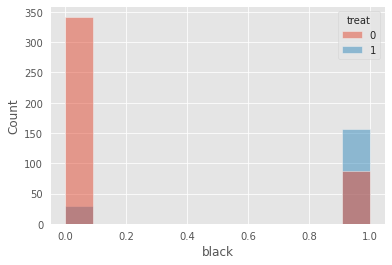

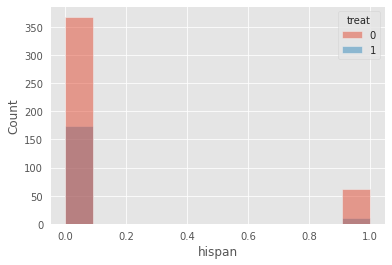

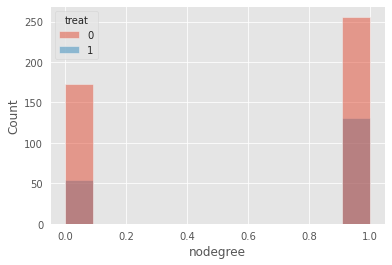

In [7]:
umbalanced=['black','hispan','nodegree']
for column in umbalanced:
    sns.histplot(data=lalonde_df,x=column,hue="treat")
    plt.show()

as we can see nonedegree is somewhat umbalanced but not as hard as hispan and blakc, this weas expectd because nonedegree's SMD is close to 0.2 

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [8]:
logit_full1 = sm.Logit(treatment, cleaned_df)
logit_full1_res = logit_full1.fit()
logit_full1_res.summary()

Optimization terminated successfully.
         Current function value: 0.416081
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            7
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                  0.3201
Time:                        17:44:39   Log-Likelihood:                -255.47
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.846e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0169      0.012     -1.445      0.149      -0.040       0.006
educ          -0.1139      0.027     -4.207      0.000      -0.167      -0.061
black          2.8090      0.264     10.622      0.000       2.291       3.327
hispan         0.4986      0.397      1.257      0.209      -0.279       1.276
married       -0.8369      0.282     -2.970      0.003      -1.389      -0.285
nodegree      -0.4511      0.227     -1.988      0.047      -0.896      -0.006
re74       -6.812e-05   2.89e-05     -2.360      0.018      -0.000   -1.15e-05
re75        4.897e-05   4.49e-05      1.090      0.276   -3.91e-05       0.000
==============================================================================
"""

black, hispan, married and nodegree aaffct the predicted output hwhere as age and education affect the less

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

[0.41159325 0.20593225 0.71809075 0.65666816 0.70864993 0.7232847
 0.74140954 0.63737378 0.64897523 0.059437   0.73331602 0.72575474
 0.75810704 0.48139108 0.78128084 0.71045504 0.70511845 0.69635427
 0.6826583  0.73157122 0.67174312 0.09214477 0.10730362 0.66800594
 0.71391902 0.44468077 0.66424748 0.17537002 0.71735804 0.66800594
 0.71735804 0.74857229 0.4614297  0.75100999 0.73487685 0.62348846
 0.79669822 0.55389945 0.45816634 0.69276913 0.7478365  0.14215655
 0.76119256 0.11868159 0.68282354 0.4614297  0.76119256 0.73987356
 0.79669822 0.74140954 0.7257835  0.4363508  0.69009795 0.73487685
 0.4405116  0.71735804 0.66980884 0.59204852 0.41763557 0.11144889
 0.76119256 0.72240732 0.65185483 0.65666816 0.80409753 0.70253873
 0.65666816 0.16283875 0.54758674 0.69804234 0.70605823 0.63429814
 0.79740664 0.73487685 0.65182204 0.10652633 0.7446363  0.72665425
 0.60558405 0.67545867 0.73487685 0.75727646 0.11824133 0.70511845
 0.72913402 0.61362756 0.22224974 0.6604681  0.15162679 0.73575

<AxesSubplot:xlabel='pscore', ylabel='Count'>

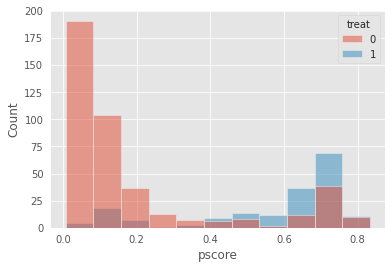

In [9]:
pscore_logit=logit_full1_res.predict()
print(pscore_logit)
lalonde_df['pscore']=pscore_logit
sns.histplot(data=lalonde_df,x='pscore',hue="treat")

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [10]:
treat_pscores=lalonde_df[lalonde_df['treat']==1]['pscore']
control_pscores=lalonde_df[lalonde_df['treat']==0]['pscore']
knn = neighbors.NearestNeighbors(n_neighbors=5, metric='euclidean').fit(treat_pscores.values.reshape(-1,1))

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

In [11]:
distances, indices = knn.kneighbors(control_pscores.values.reshape(-1,1))

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

In [14]:
match_indices=indices[:,0]
pscores=list()
for i in range(len(control_df)):
    pscores.append(treat_pscores[match_indices[i]])
control_df['pscore']=pscores

print(control_df)

         treat  age  educ  black  hispan  married  nodegree      re74  \
PSID1        0   30    12      0       0        1         0  20166.73   
PSID2        0   26    12      0       0        1         0  25862.32   
PSID3        0   25    16      0       0        1         0  25862.32   
PSID4        0   42    11      0       0        1         1  21787.05   
PSID5        0   25     9      1       0        1         1  14829.69   
...        ...  ...   ...    ...     ...      ...       ...       ...   
PSID425      0   18    11      0       0        0         1      0.00   
PSID426      0   24     1      0       1        1         1      0.00   
PSID427      0   21    18      0       0        0         0      0.00   
PSID428      0   32     5      1       0        1         1      0.00   
PSID429      0   16     9      0       0        0         1      0.00   

             re75        re78    pscore  
PSID1    18347.23  25564.6700  0.033204  
PSID2    17806.55  25564.6700  0.033204

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

<AxesSubplot:xlabel='pscore', ylabel='Density'>

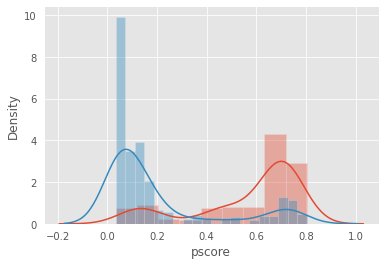

In [23]:
sns.distplot(treat_pscores)
sns.distplot(control_df['pscore'])
control_pscores=control_df['pscore']

### Exercise 6

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [29]:
group1= lalonde_df[lalonde_df['treat']==1]
group2=lalonde_df[lalonde_df['treat']==0]
sd1=group1.std()
sd2=group2.std()
mu1=treat_pscores.mean()
mu2=control_pscores.mean()
ASMD=(mu1-mu2)/((sd1**2 + sd2**2)/2)**1/2
print(ASMD)

treat                inf
age         2.214351e-03
educ        3.042255e-02
black       1.257858e+00
hispan      2.078631e+00
married     9.168574e-01
nodegree    8.262599e-01
re74        5.302647e-09
re75        1.749961e-08
re78        3.223314e-09
pscore      3.660085e+00
dtype: float64


### Exercise 7

Estimate the average effect of treatment on wages (`re78`) after matching. What do you conclude?

**Answer.**

In [31]:
print("re78 before martching")
print(lalonde_df['re78'].mean())
re78=list()
for i in range(len(control_df)):
    re78.append(treatment_df['re78'][match_indices[i]])
control_df['re78']=re78
print("re78 after martching")
print((control_df['re78'].mean()+treatment_df['re78'].mean())/2)
print("improvement")
print(((control_df['re78'].mean()+treatment_df['re78'].mean())/2 )-lalonde_df['re78'].mean())

re78 before martching
6792.8344829804555
re78 after martching
6252.685702664273
improvement
-540.1487803161826


based on the matching the effect of the treatment was not positive

## Propensity score matching using decision trees and random forests

### Exercise 8

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

-------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

-------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

-------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

True, the AUC provides better estmates, but higher AUC in train doesn't mean better model, what matters is the performance in the real application or in the test set

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

-------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

the balancing isn't as good because the distances are higher so we have the nearest neighbors but they arent necesarily a good representative neighbor